In [13]:
import os, click, math
from LxGeoPyLibs.satellites.imd import IMetaData
from LxGeoPyLibs.satellites.formulas import compute_rotation_angle, compute_roof2roof_constants, nicolas_roof2roof
import geopandas as gpd
import rasterio as rio
from rasterio import plot
from rasterio import windows
from shapely import wkt
from LxGeoPyLibs.geometry.utils_rio import extents_to_profile, window_round
from LxGeoPyLibs.geometry.rasterizers.polygons_rasterizer import rasterize_from_profile
import cv2
from matplotlib import pyplot as plt
from pathlib import Path
from matplotlib.patches import Arrow, Circle
import numpy as np
from skimage import filters
import shapely.geometry
from skimage.draw import line_aa
from collections import defaultdict
from functools import partial
import copy

In [ ]:
top_dir = Path("/home/mcherif/Documents/DATA_SANDBOX/maskedMatching/paris_tri_stereo_dataset/extracted/")
input_reference_image_1 = top_dir / "PHR1A_acq20180326_del1b382d54/pre_processed/SHARP_PHR1A_acq20180326_del1b382d54.tif"
input_imd_1 = top_dir / "PHR1A_acq20180326_del1b382d54/DIM_PHR1A_P_201803261058106_ORT_d6f1e4b3-d871-4632-c636-be3f35ac8f6e-001.XML"
input_reference_image_2 = top_dir / "PHR1A_acq20180326_dela9229d3e/pre_processed/SHARP_PHR1A_acq20180326_dela9229d3e.tif"
input_imd_2 = top_dir / "PHR1A_acq20180326_dela9229d3e/DIM_PHR1A_P_201803261058555_ORT_d1e09bbc-25a7-4ed0-ce43-9fe1a017920b-001.XML"
input_geom_arg = top_dir / "../prediction/PHR1A_acq20180326_dela9229d3e/buildings.shp"
#input_geom_arg = "Polygon ((449461.62446757068391889 5415990.87634366285055876, 449464.41643805534113199 5415984.15281194821000099, 449466.28154301166068763 5415979.66132738720625639, 449476.06624570902204141 5415956.09812739305198193, 449446.13259824673878029 5415943.66807369701564312, 449437.95442754047689959 5415940.27205919101834297, 449437.79295110510429367 5415940.66092144418507814, 449436.9003770524286665 5415942.81038899067789316, 449407.04743578378111124 5415930.41384882852435112, 449397.76714828371768817 5415948.87472698837518692, 449402.10814802179811522 5415951.06816691905260086, 449404.31319829361746088 5415952.18234466761350632, 449402.40858454798581079 5415955.97111115884035826, 449441.01312617113580927 5415975.47738810162991285, 449438.6938451534952037 5415980.70716938097029924, 449452.37124866776866838 5415986.77276574913412333, 449455.40177035098895431 5415988.11672853399068117, 449459.22224441781872883 5415989.81101602129638195, 449461.62446757068391889 5415990.87634366285055876))"
input_geometry_idx = 33687#34775#26670#26770#26391

# Load geometry from arguments
if os.path.isfile(input_geom_arg) or os.path.isdir(input_geom_arg):
    input_geom = gpd.read_file(input_geom_arg).geometry[input_geometry_idx]
else:
    assert input_geometry_idx == 0, "--input_geometry_idx should not be provided with wkt argumetn!"
    input_geom = wkt.loads(input_geom_arg)

In [ ]:
from typing import List, TypedDict, Union
import ipywidgets as widgets
from ipywidgets import interact

class visualMatcher:

    BUFF_SIZE = 100
    default_matching_methods = {
        "TM_CCOEFF":cv2.TM_CCOEFF,
        "TM_CCOEFF_NORMED": cv2.TM_CCOEFF_NORMED, 
        "TM_CCORR" : cv2.TM_CCORR,
        "TM_CCORR_NORMED": cv2.TM_CCORR_NORMED,
        "TM_SQDIFF": cv2.TM_SQDIFF,
        "TM_SQDIFF_NORMED": cv2.TM_SQDIFF_NORMED
        }

    def __init__(self, input_reference_image_1, input_imd_1, input_reference_image_2, input_imd_2, input_geom, apply_mask=True, epipolar_weight=True):
        
        self.input_geom = input_geom
        imd1_obj = IMetaData(input_imd_1)
        imd2_obj = IMetaData(input_imd_2)
        self.r2r_constant = compute_roof2roof_constants(
            math.radians(imd1_obj.satAzimuth()),
            math.radians(imd1_obj.satElevation()),
            math.radians(imd2_obj.satAzimuth()),
            math.radians(imd2_obj.satElevation())
            )
        self.template_mask=None
        if apply_mask:        
            rasterization_profile = extents_to_profile(input_geom.bounds)
            self.template_mask = rasterize_from_profile([input_geom], rasterization_profile, 1)
        self.epipolar_weight = epipolar_weight
        self._init_plot()

    
    def _init_plot(self):
        """
        init fig, ax, template_img, search_img, geom_gdf attributes
        """
        #self.fig, self.ax = plt.subplots(2,len(self.default_matching_methods), figsize=(15, 4))
        
        self.fig = plt.figure(figsize=(10, 6))
        gs = self.fig.add_gridspec(2,len(self.default_matching_methods), height_ratios=[5,3])
        self.ax = []
        self.ax.append( [self.fig.add_subplot(gs[0, 0:3])] )
        self.ax[0].append( self.fig.add_subplot(gs[0, 3:]) )
        self.ax.append( [self.fig.add_subplot(gs[1, i]) for i in range(len(self.default_matching_methods))] ) 

        # init search image ax
        with rio.open(input_reference_image_1) as search_dst:
            search_window = window_round(windows.from_bounds(*self.input_geom.bounds, search_dst.transform))
            search_window = windows.Window(search_window.col_off-self.BUFF_SIZE, search_window.row_off-self.BUFF_SIZE,
             search_window.width+2*self.BUFF_SIZE, search_window.height+2*self.BUFF_SIZE)
            self.gsd = search_dst.transform[0]
            self.search_img = search_dst.read(window=search_window)[:3]
            rio.plot.show(self.search_img, transform=rio.windows.transform(search_window, search_dst.transform), ax=self.ax[0][0])
            self.ax[0][0].title.set_text("Search image")
        
        with rio.open(input_reference_image_2) as template_dst:
            template_window = window_round(windows.from_bounds(*self.input_geom.bounds, template_dst.transform))
            self.template_img = template_dst.read(window=template_window)[:3]
            rio.plot.show(self.template_img, transform=rio.windows.transform(template_window, template_dst.transform), ax=self.ax[0][1], )
            self.ax[0][1].title.set_text("template patch")
            self.geom_gdf = gpd.GeoDataFrame(geometry=[self.input_geom], crs=template_dst.crs)

        self.geom_gdf.plot(ax=self.ax[0][0], facecolor='none', edgecolor='green')
        def get_line_from_point(sample_point):
            s1 = shapely.geometry.Point(sample_point.x-self.r2r_constant[0]*self.BUFF_SIZE/self.gsd, sample_point.y-self.r2r_constant[1]*self.BUFF_SIZE/self.gsd)
            s2 = shapely.geometry.Point(sample_point.x+self.r2r_constant[0]*self.BUFF_SIZE/self.gsd, sample_point.y+self.r2r_constant[1]*self.BUFF_SIZE/self.gsd)
            l12 = shapely.geometry.LineString([s1,s2])
            return l12
        self.ax[0][0].plot(*get_line_from_point(self.geom_gdf.geometry[0].centroid).xy, color="yellow", alpha=0.6, linestyle='dashed')
        minx,miny,maxx,maxy = self.geom_gdf.geometry[0].bounds
        self.ax[0][0].plot(*get_line_from_point(shapely.geometry.Point(minx,maxy)).xy, color="yellow", alpha=0.6, linestyle='dashed')
        self.ax[0][0].plot(*get_line_from_point(shapely.geometry.Point(maxx,miny)).xy, color="yellow", alpha=0.6, linestyle='dashed')
        self.geom_gdf.plot(ax=self.ax[0][1], facecolor='none', edgecolor='green')

        self.matching_dict = self.compute_matching()
        self.matching_label = display('', display_id = True)
        for matching_idx, (match_key,match_val) in enumerate(self.matching_dict.items()):
            c_ax = self.ax[1][matching_idx]
            c_im = c_ax.imshow(match_val)
            #self.fig.colorbar(c_im, cax=c_ax)
            c_ax.title.set_text(match_key)
            c_ax.title.set_fontsize(8)
        
        interaction_shape = [(s-t+1) for s,t in zip(self.search_img.shape, self.template_img.shape)]
        interact(self.update_plot, x=(0,interaction_shape[1]), y=(0,interaction_shape[2]))


        def update_to_best(match_key):
            match_key=match_key.owner.value
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(self.matching_dict[match_key])
            if match_key in ["TM_SQDIFF", "TM_SQDIFF_NORMED"]:
                top_left = min_loc
            else:
                top_left = max_loc
            self.update_plot(*top_left)

        toggle = widgets.ToggleButtons(
            options=list(self.matching_dict.keys()),
            description='Go to:',
            disabled=False,
        )
        toggle.observe(update_to_best)
        display(toggle)

    def create_weight_map(self):
        
        constants_ratio = self.r2r_constant[0]/self.r2r_constant[1]
        patch_size = 2*self.BUFF_SIZE
        if abs(constants_ratio)<1:

            st_pt = (
                0,
                round( constants_ratio*self.gsd * patch_size + patch_size/2 )
            )
            end_pt = (
                patch_size-1,
                patch_size-st_pt[1]
            )
        else:
            st_pt = (
                round(1/constants_ratio*self.gsd*patch_size + patch_size/2),
                0
            )
            end_pt = (
                patch_size-st_pt[0],
                patch_size-1
            )

        weight_map = np.zeros((2*self.BUFF_SIZE+1, 2*self.BUFF_SIZE+1))
        rr, cc, val = line_aa(*st_pt, *end_pt)
        weight_map[rr, cc] = val
        weight_map = filters.gaussian(weight_map, sigma = 0.1); weight_map/=weight_map.max()
        return weight_map
    
    def compute_matching(self, matching_methods =None):
        if not matching_methods:
            matching_methods = self.default_matching_methods

        if self.epipolar_weight:
            weight_map = self.create_weight_map()
            post_comp_fn = lambda arr, method_name: arr/(1e-5+weight_map) if method_name in ["TM_SQDIFF", "TM_SQDIFF_NORMED"] else arr*weight_map
        else:
            post_comp_fn = lambda arr, method_name:arr
        matching_results = {}
        for method_name, method_key in matching_methods.items():
            s_img = self.search_img[0]#filters.scharr(self.search_img[0]).astype(np.float32)#self.search_img[0]
            t_img = self.template_img[0]#filters.scharr(self.template_img[0]).astype(np.float32)#self.template_img[0]
            c_match_res = cv2.matchTemplate(s_img,t_img,method = method_key, mask=self.template_mask)
            matching_results[method_name] = post_comp_fn(c_match_res, method_name)
        return matching_results
    
    def remove_patches(self):
        if len(self.ax[0][0].collections)>1: self.ax[0][0].collections[-1].remove()
        for c_ax in self.ax[1]:
            if c_ax.patches: c_ax.patches[0].remove()

    def update_plot(self, x=None, y=None):
        if x is None:
            x=self.search_img.shape[0]/2 -self.BUFF_SIZE
            y=self.search_img.shape[1]/2 -self.BUFF_SIZE
        self.remove_patches()
        for c_ax in self.ax[1]:
            c_ax.add_patch(Circle((x, y), radius=self.BUFF_SIZE/30, color ='red'))
        self.geom_gdf.translate((x- self.BUFF_SIZE)*self.gsd , -(y- self.BUFF_SIZE)*self.gsd ).plot(ax=self.ax[0][0], facecolor='none', edgecolor='red') #
        
        items = "".join([f"{match_key}: {match_arr[y,x]} || " for match_key, match_arr in self.matching_dict.items()])
        self.matching_label.update(items)

In [ ]:
%matplotlib ipympl
plt.rc('xtick', labelsize=4)    # fontsize of the tick labels
plt.rc('ytick', labelsize=4)
vis_proj = visualMatcher(input_reference_image_1, input_imd_1, input_reference_image_2, input_imd_2, input_geom, True, True)

In [133]:
from typing import List, TypedDict, Union
import ipywidgets as widgets
from ipywidgets import interact
DEFAULT_BUFF_SIZE = 100

class multiVisualMatcher:

    default_matching_methods = {
        "TM_CCOEFF":cv2.TM_CCOEFF,
        "TM_CCOEFF_NORMED": cv2.TM_CCOEFF_NORMED, 
        "TM_CCORR" : cv2.TM_CCORR,
        "TM_CCORR_NORMED": cv2.TM_CCORR_NORMED,
        "TM_SQDIFF": cv2.TM_SQDIFF,
        "TM_SQDIFF_NORMED": cv2.TM_SQDIFF_NORMED
        }

    def __init__(self, input_reference_image_1, input_imd_1, input_reference_image_2, input_imd_2, input_geoms,
     apply_mask=True, epipolar_weight_sigma=1.0, buff_size=DEFAULT_BUFF_SIZE, image_transformer_fn=lambda x:x[0]
     ):
        """
        Arguments: requiered file paths for reference images and corresponding imd.
            - input_geoms: list of shapely geometries
            - apply_mask: boolean corresponding to usage of masks during template matching
            - epipolar_weight_sigma: sigma value used to smooth weight along epipolar parallax. If None, no weight is applied
        """
        self.irim1=input_reference_image_1
        self.irim2=input_reference_image_2
        self.iimd1=input_imd_1
        self.iimd2=input_imd_2

        self.input_geoms = input_geoms
        with rio.open(self.irim2) as template_dst:
            self.geom_gdf = gpd.GeoDataFrame(geometry=self.input_geoms, crs=template_dst.crs).reset_index()
        self.imd1_obj = IMetaData(input_imd_1)
        self.imd2_obj = IMetaData(input_imd_2)
        self.r2r_constant = compute_roof2roof_constants(
            math.radians(self.imd1_obj.satAzimuth()),
            math.radians(self.imd1_obj.satElevation()),
            math.radians(self.imd2_obj.satAzimuth()),
            math.radians(self.imd2_obj.satElevation())
            )
        self.template_masks=defaultdict(lambda :None)
        if apply_mask:        
            for c_geom_idx, c_geom in enumerate(self.input_geoms):
                self.template_masks[c_geom_idx]=self.compute_template_mask(c_geom)
        self.epipolar_weight_sigma = epipolar_weight_sigma
        self.buff_size=buff_size
        self.image_transformer_fn=image_transformer_fn
        self._init_grid(len(self.default_matching_methods), len(self.input_geoms))
        self._def_ui()
        self.geometries_shadows = defaultdict(list)
        self.load_images()
        self.matching_result_dict = self.compute_matching()
        self.static_plot()        
        self._init_ui()
        self.plot_matching_result(0)

    def _init_grid(self, matching_methods_count, num_geoms):
        self.fig = plt.figure(figsize=(7, 7), constrained_layout = True)
        grid_rows = 2; grid_columns = 2+max(matching_methods_count, num_geoms);
        gs = self.fig.add_gridspec(2, 1, wspace=0.0, hspace=0.0)

        gs1 = gs[0].subgridspec(1,1)
        gs2 = gs[1].subgridspec(1, grid_columns)

        self.axes = {"search_view": self.fig.add_subplot(gs1[0, 0])}

        self.axes[f"geoms_views"] = []
        ax_per_geom = (grid_columns-2)//num_geoms
        for c_geom_idx in range(num_geoms):
            pass
            #self.axes["geoms_views"].append( self.fig.add_subplot(gs[0, 2+c_geom_idx*ax_per_geom: 2+(c_geom_idx+1)*ax_per_geom]) )
        self.axes["match_views"] = []
        for c_matching_idx in range(matching_methods_count):
            self.axes["match_views"].append( self.fig.add_subplot(gs2[0, c_matching_idx]) )
    
    def compute_template_mask(self, ref_geometry, **kwargs):
        rasterization_profile = extents_to_profile(ref_geometry.bounds, **kwargs)
        template_mask = rasterize_from_profile([ref_geometry], rasterization_profile, 1)
        return template_mask
    
    def _def_ui(self):

        geometries_ids = list(range(len(self.input_geoms)))
        self.UI = dict()
        self.UI["geom_selector"] = widgets.SelectMultiple(
            options=geometries_ids,
            value=geometries_ids,
            #rows=10,
            description='Geometries selector',
            disabled=False
        )
        
        self.UI["translate_x"] = widgets.IntSlider(
            value=self.buff_size//2,
            min=0,
            max=self.buff_size,
            step=1,
            description='X slider:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        self.UI["translate_y"] = widgets.IntSlider(
            value=self.buff_size//2,
            min=0,
            max=self.buff_size,
            step=1,
            description='Y slider:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )

        self.UI["translate_h"] = widgets.IntSlider(
            value=0,
            min=-self.buff_size,
            max=self.buff_size,
            step=1,
            description='Height slider:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        
        self.UI["matcher_metric"] = widgets.ToggleButtons(
            options=list(self.default_matching_methods.keys()),
            description='Go to best match:',
            disabled=False,
        )
        
        self.UI["corresponding_match_plot"] = widgets.Dropdown(
            options=geometries_ids,
            value=0,
            description='Plot match result corresponding to geometry:',
            disabled=False,
        )
        
        self.UI["base_image_plot"] = widgets.RadioButtons(
            options=['Search image', 'Template image'],
             value='Search image',
            description='Show map:',
            disabled=False
        )
        
        for widget in self.UI.values():
            display(widget)
    
    def _init_ui(self):

        self.UI["geom_selector"].observe(
            lambda observable: self.update_plot({geom_idx: None for geom_idx in observable.owner.value}) , names=['value']
        )

        self.UI["matcher_metric"].observe(
            lambda observable: self.update_plot({geom_idx: self.get_best_match(geom_idx, match_method=observable.owner.value) for geom_idx in self.UI["geom_selector"].value}), names=['value']
        )

        self.UI["corresponding_match_plot"].observe(
            lambda observable: self.plot_matching_result(observable.owner.value), names=['value']
        )
        self.UI["base_image_plot"].observe(
            lambda observable: self.static_plot(show_map=observable.owner.value), names=['value']
        )

        self.UI["translate_x"].observe(
            lambda observable : self.update_plot( {geom_idx:(observable.owner.value, self.UI["translate_y"].value) for geom_idx in self.UI["geom_selector"].value } )
            )
        self.UI["translate_y"].observe(
            lambda observable : self.update_plot( {geom_idx:(self.UI["translate_x"].value, observable.owner.value) for geom_idx in self.UI["geom_selector"].value } )
            )
        
        self.UI["translate_h"].observe(
            lambda observable: self.update_plot( {geom_idx:(observable.owner.value*self.r2r_constant[0]*self.gsd, -observable.owner.value*self.r2r_constant[1]*self.gsd) for geom_idx in self.UI["geom_selector"].value } )
        )

    def load_images(self):
        self.search_images=[]
        self.templates_images=[]
        self.template_transforms=[]
        self.total_search_view_images = {}
        with rio.open(self.irim1) as search_dst:
            self.gsd = search_dst.transform[0]
            for c_geom in self.input_geoms:
                search_window = window_round(windows.from_bounds(*c_geom.bounds, search_dst.transform))
                search_window = windows.Window(search_window.col_off-self.buff_size, search_window.row_off-self.buff_size,
                    search_window.width+2*self.buff_size, search_window.height+2*self.buff_size
                )
                self.search_images.append( search_dst.read(window=search_window)[:3] )
            
            self.total_search_view_window = window_round(windows.from_bounds(*shapely.geometry.box(*self.geom_gdf.total_bounds).buffer(50).bounds, search_dst.transform))
            self.total_search_view_images["Search image"] = search_dst.read(window=self.total_search_view_window)[:3]
       
        with rio.open(self.irim2) as template_dst:
            for c_geom in self.input_geoms:
                template_window = window_round(windows.from_bounds(*c_geom.bounds, template_dst.transform))
                template_transform=rio.windows.transform(template_window, template_dst.transform)
                self.templates_images.append( template_dst.read(window=template_window)[:3] )
                self.template_transforms.append(template_transform)
                self.total_search_view_images["Template image"] = template_dst.read(window=self.total_search_view_window)[:3]

    def compute_matching(self):
        matching_result_dict = dict()
        if self.epipolar_weight_sigma:
            weight_map = self.create_weight_map(self.epipolar_weight_sigma)
            post_comp_fn = lambda arr, method_name: arr/(1e-5+weight_map) if method_name in ["TM_SQDIFF", "TM_SQDIFF_NORMED"] else arr*weight_map
        else:
            post_comp_fn = lambda arr, method_name:arr
        for geom_idx in range(len(self.input_geoms)):
            c_geom_matching_results = {}
            for method_name, method_key in self.default_matching_methods.items():
                s_img = self.image_transformer_fn(self.search_images[geom_idx])
                t_img = self.image_transformer_fn(self.templates_images[geom_idx])
                c_match_res = cv2.matchTemplate(s_img,t_img,method = method_key, mask=self.template_masks[geom_idx])
                c_geom_matching_results[method_name] = post_comp_fn(c_match_res, method_name)
            matching_result_dict[geom_idx] = c_geom_matching_results
        return matching_result_dict

    def static_plot(self, to_plot_geom=None, show_map="Search image", matcher_metric=None):
        if to_plot_geom is None:
            to_plot_geom = self.geom_gdf.index 
        if not matcher_metric:
            matcher_metric = self.UI["matcher_metric"].value
        search_view_ax = self.axes[f"search_view"]
        x_bound, y_bound = search_view_ax.get_xbound(), search_view_ax.get_ybound()

        with rio.open(self.irim1) as search_dst:            
            image_to_plot = self.total_search_view_images[show_map]
            search_view_ax.cla()
            rio.plot.show(image_to_plot, transform=rio.windows.transform(self.total_search_view_window, search_dst.transform), ax=search_view_ax)
            search_view_ax.title.set_text(show_map)
            self.fig.canvas.draw_idle()
            self.update_plot({geom_idx: self.get_best_match(geom_idx, match_method=matcher_metric) for geom_idx in range(len(self.input_geoms))})
        
        if x_bound[0]!=0:
            search_view_ax.set_xlim(*x_bound), search_view_ax.set_ylim(*y_bound)
        
        self.geom_gdf.loc[self.geom_gdf.index.isin(to_plot_geom)].plot(ax=search_view_ax, facecolor='none', edgecolor='green')
        self.geom_gdf.apply(lambda x: search_view_ax.annotate(text=x.name, xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
        def get_line_from_point(sample_point):
            s1 = shapely.geometry.Point(sample_point.x-self.r2r_constant[0]*self.buff_size/self.gsd, sample_point.y-self.r2r_constant[1]*self.buff_size/self.gsd)
            s2 = shapely.geometry.Point(sample_point.x+self.r2r_constant[0]*self.buff_size/self.gsd, sample_point.y+self.r2r_constant[1]*self.buff_size/self.gsd)
            l12 = shapely.geometry.LineString([s1,s2])
            return l12
        
        minx,miny,maxx,maxy = self.geom_gdf.total_bounds
        search_view_ax.plot(*get_line_from_point(shapely.geometry.box(minx,miny,maxx,maxy).centroid).xy, color="yellow", alpha=0.6, linestyle='dashed')
        search_view_ax.plot(*get_line_from_point(shapely.geometry.Point(minx,maxy)).xy, color="yellow", alpha=0.3, linestyle='dashed')
        search_view_ax.plot(*get_line_from_point(shapely.geometry.Point(maxx,miny)).xy, color="yellow", alpha=0.3, linestyle='dashed')
        
        
        for t_idx,(template_image, template_transform) in enumerate(zip(self.templates_images,self.template_transforms)):
            break
            rio.plot.show(template_image, transform=template_transform, ax=self.axes["geoms_views"][t_idx] )
            self.axes["geoms_views"][t_idx].title.set_text(f"T {t_idx}")
            self.axes["geoms_views"][t_idx].title.set_fontsize(8)
            sub_gdf = self.geom_gdf[self.geom_gdf.index==t_idx]
            sub_gdf.plot(ax=self.axes["geoms_views"][t_idx], facecolor='none', edgecolor='green')
            sub_gdf.apply(lambda x: self.axes["geoms_views"][t_idx].annotate(text=x.name, xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
            #self.axes["geoms_views"][t_idx].imshow(rio.plot.reshape_as_image(template_image))

    def plot_matching_result(self, geom_idx):
        for matching_idx, (match_key,matching_array) in enumerate(self.matching_result_dict[geom_idx].items()):
            c_ax = self.axes["match_views"][matching_idx]
            c_ax.cla()
            c_im = c_ax.imshow(matching_array)
            self.fig.canvas.draw_idle()
            c_ax.title.set_text(match_key)
            c_ax.title.set_fontsize(8)
    
    def update_plot(self, geoms_position_dict):
        """
        A dict with keys as corresponding geom indices and values as tuple of (x,y) position in search_space
        """
        for c_geom_idx in geoms_position_dict.keys(): ## is it geoms_position_dict? for filtered view
            self.update_plot_single_geom(c_geom_idx, geoms_position_dict.get(c_geom_idx, None))
            
    def update_plot_single_geom(self, geom_idx, position=None):
        if position is None:
            x,y = self.buff_size, self.buff_size
        else:
            x,y=position        
        self.remove_shadows_single_geom(geom_idx)
        self.add_shadows_single_geom(geom_idx, x=x, y=y)
    
    def remove_shadows_single_geom(self, geom_idx):
        while len(self.geometries_shadows[geom_idx])>0:
            collection, el = self.geometries_shadows[geom_idx].pop()
            collection_list =list(collection)
            if el in collection_list:
                pos = collection_list.index(el)
                collection[pos].remove()
    
    def add_shadows_single_geom(self, geom_idx, x, y):
        self.geom_gdf[self.geom_gdf.index == geom_idx].translate(
            (x- self.buff_size)*self.gsd,
            -(y- self.buff_size)*self.gsd
        ).plot(ax=self.axes["search_view"], facecolor='none', edgecolor='red')
        self.geometries_shadows[geom_idx].append((self.axes["search_view"].collections, self.axes["search_view"].collections[-1]))
        if self.UI["corresponding_match_plot"].value != geom_idx:
            return
        for c_match_idx, c_match_ax in enumerate(self.axes["match_views"]):
            c_match_ax.add_patch(Circle((x, y), radius=self.buff_size/30, color ='red'))
            self.geometries_shadows[geom_idx].append((self.axes["match_views"][c_match_idx].patches, self.axes["match_views"][c_match_idx].patches[-1]))

    def get_best_match(self, geom_idx, match_method):
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(self.matching_result_dict[geom_idx][match_method])
        if match_method in ["TM_SQDIFF", "TM_SQDIFF_NORMED"]:
            top_left = min_loc
        else:
            top_left = max_loc
        return top_left

    def create_weight_map(self, epipolar_weight_sigma):
        
        constants_ratio = self.r2r_constant[0]/self.r2r_constant[1]
        patch_size = 2*self.buff_size
        if abs(constants_ratio)<1:

            st_pt = (
                0,
                round( constants_ratio*self.gsd * patch_size + patch_size/2 )
            )
            end_pt = (
                patch_size-1,
                patch_size-st_pt[1]
            )
        else:
            st_pt = (
                round(1/constants_ratio*self.gsd*patch_size + patch_size/2),
                0
            )
            end_pt = (
                patch_size-st_pt[0],
                patch_size-1
            )

        weight_map = np.zeros((2*self.buff_size+1, 2*self.buff_size+1))
        rr, cc, val = line_aa(*st_pt, *end_pt)
        weight_map[rr, cc] = val
        weight_map = filters.gaussian(weight_map, sigma = epipolar_weight_sigma); weight_map/=weight_map.max()
        return weight_map
    

In [82]:
%matplotlib ipympl
top_dir = Path("/home/mcherif/Documents/DATA_SANDBOX/maskedMatching/paris_tri_stereo_dataset/extracted/")
input_reference_image_1 = top_dir / "../prediction/PHR1A_acq20180326_del1b382d54/build_probas.tif"
input_imd_1 = top_dir / "PHR1A_acq20180326_del1b382d54/DIM_PHR1A_P_201803261058106_ORT_d6f1e4b3-d871-4632-c636-be3f35ac8f6e-001.XML"
input_reference_image_2 = top_dir / "../prediction/PHR1A_acq20180326_dela9229d3e/build_probas.tif"
input_imd_2 = top_dir / "PHR1A_acq20180326_dela9229d3e/DIM_PHR1A_P_201803261058555_ORT_d1e09bbc-25a7-4ed0-ce43-9fe1a017920b-001.XML"
input_geom_arg = top_dir / "../prediction/PHR1A_acq20180326_dela9229d3e/buildings.shp"
input_geometry_indices = [74937]#, 74937, 75091, 75108, 75109, 75121, 75143, 75150, 75151, 75152, 75202, 75220, 75244, 75256, 75272]

# Load geometry from arguments
if os.path.isfile(input_geom_arg) or os.path.isdir(input_geom_arg):
    in_gdf = gpd.read_file(input_geom_arg)
    in_geoms = in_gdf[in_gdf.index.isin(input_geometry_indices)].geometry
else:
    assert input_geometry_idx == 0, "--input_geometry_idx should not be provided with wkt argumetn!"
    input_geom = wkt.loads(input_geom_arg)


SelectMultiple(description='Geometries selector', index=(0,), options=(0,), value=(0,))

IntSlider(value=50, continuous_update=False, description='X slider:')

IntSlider(value=50, continuous_update=False, description='Y slider:')

IntSlider(value=50, continuous_update=False, description='Height slider:')

ToggleButtons(description='Go to best match:', options=('TM_CCOEFF', 'TM_CCOEFF_NORMED', 'TM_CCORR', 'TM_CCORR…

Dropdown(description='Plot match result corresponding to geometry:', options=(0,), value=0)

RadioButtons(description='Show map:', options=('Search image', 'Template image'), value='Search image')

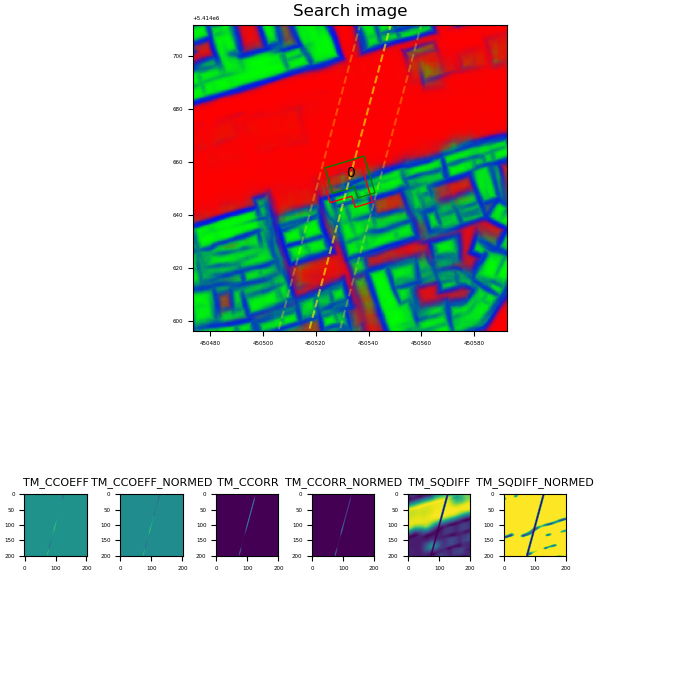

In [134]:
plt.rc('xtick', labelsize=4)    # fontsize of the tick labels
plt.rc('ytick', labelsize=4)
vis_proj = multiVisualMatcher(input_reference_image_1, input_imd_1, input_reference_image_2, input_imd_2, in_geoms,
                               apply_mask=False, epipolar_weight_sigma=0.5, buff_size=100,
 )# image_transformer_fn=lambda x: filters.sobel(x[0]).astype(np.float32))